# [Exploration 15] 한국어 데이터로 챗봇 만들기
## 프로젝트 설명 
---
DCGAN을 이용해 CIFAR-10 이미지를 생선하는 프로젝트


## 프로젝트 정리     
---        
1. 데이터 수집
2. 데이터 전처리
    - SubwordTextEncoder 사용
        - 형태소분석기가 아닌 SubwordTextEncoder를 사용합니다.
3. teacher forcing 사용하기 및 데이터셋 구성
4. Transformer 모델 구현 및 학습
5. 모델 평가 


## 프로젝트 목표
---
- 한국어 데이터 전처리 
- SubwordTextEncoder 이해
- Transformer 구현


## 01. 데이터 다운로드 
- 한국어 챗봇 데이터 소스 : [송영숙 님 깃허브](https://github.com/songys/Chatbot_data/blob/master/ChatbotData%20.csv)
    - 챗봇 트레이닝용 문답 페어 11,876개
    - 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
file_path = os.getenv('HOME')+'/aiffel/songys_chatbot/ChatbotData .csv'  # 주의 ! 파일명에 띄어쓰기가 있어요
file_path

'/home/aiffel-dj26/aiffel/songys_chatbot/ChatbotData .csv'

In [45]:
data = pd.read_csv(file_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
len(data)

11823

**데이터 갯수가 적기때문에 전체를 사용합니다.**

- 결측치 확인

In [5]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [6]:
print(data['Q'][0])
print(data['A'][0])

12시 땡!
하루가 또 가네요.


## 02. 데이터 전처리

In [120]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'([?.!,])', r' \1 ', sentence)
    sentence = re.sub(r'[" "]+', ' ', sentence)
    return sentence

In [8]:
def load_conversations():
    questions, answers = [], []
    for q, a in zip(data['Q'], data['A']):
        questions.append(preprocess_sentence(q))
        answers.append(preprocess_sentence(a))
        
        if len(questions) >= len(data):
            return questions, answers
    return questions, answers

In [27]:
questions, answers = load_conversations()
print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))

전체 질문 수 : 11823
전체 답변 수 : 11823


- 문장부호(.!,?)와 단어 사이 띄어쓰기가 잘 되었는지 확인합니다.
- 질문과 답변이 병렬로 전처리 되었는지 확인합니다. 

In [11]:
print('전처리 후 11번째 질문 샘플: {}'.format(questions[11]))
print('전처리 후 11번째 답변 샘플: {}'.format(answers[11]))

전처리 후 11번째 질문 샘플: 가끔 궁금해
전처리 후 11번째 답변 샘플: 그 사람도 그럴 거예요 . 


- **단어장** 만들기

In [12]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [13]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [14]:
print('START_TOKEN의 번호:', [tokenizer.vocab_size])
print('END_TOKEN의 번호:', [tokenizer.vocab_size + 1])

START_TOKEN의 번호: [8170]
END_TOKEN의 번호: [8171]


In [15]:
VOCAB_SIZE = tokenizer.vocab_size + 2  # STRAT, END TOKEN 추가 
print(VOCAB_SIZE)

8172


**tokenizer를 정의하고 vocabulary를 만들었습니다.**

- 각 단어를 정수로 인코딩 후 패딩하겠습니다.
- tokenizer.encdoe() 사용

In [16]:
print('정수 인코딩 후 11번째 질문 샘플: {}'.format(tokenizer.encode(questions[11])))
print('정수 인코딩 후 11번째 답변 샘플: {}'.format(tokenizer.encode(answers[11])))

정수 인코딩 후 11번째 질문 샘플: [684, 745]
정수 인코딩 후 11번째 답변 샘플: [62, 513, 137, 3, 1]


- 패딩을 위해 문장의 최대 길이를 설정해야합니다.
- 시각화를 통해 길이 분포를 확인하겠습니다.

16
24


Text(0.5, 1.0, 'answer length')

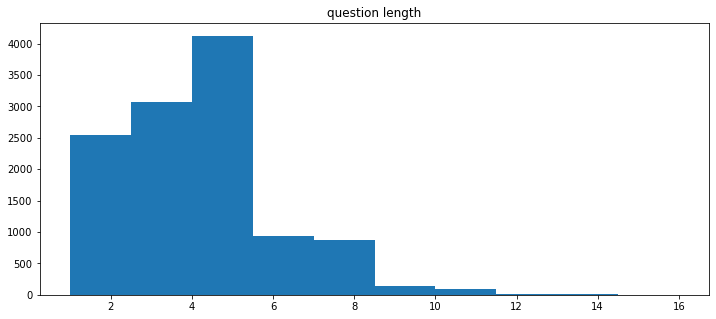

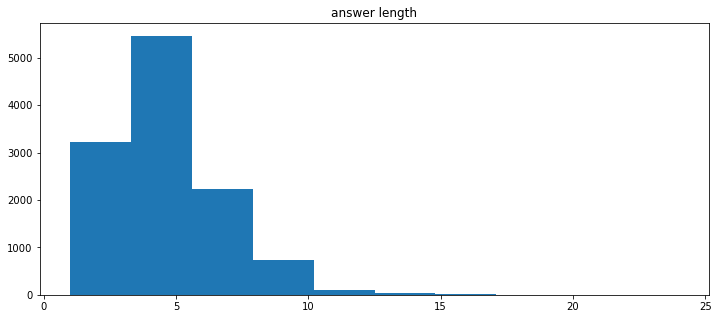

In [17]:
import matplotlib.pyplot as plt 

question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print(max(question_len))
print(max(answer_len))

plt.figure(figsize=(12, 5))
plt.hist(question_len)
plt.title('question length')

plt.figure(figsize=(12, 5))
plt.hist(answer_len)
plt.title('answer length')

**분포를 확인했으나, 전체 데이터를 사용하기 위해 최대 길이는 30으로 하겠습니다.**

In [18]:
MAX_LENGTH = 30
print(MAX_LENGTH)

30


In [30]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')        

    return tokenized_inputs, tokenized_outputs

In [31]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장 크기:', (VOCAB_SIZE))
print('필터링 후 질문 샘플 개수:{}'.format(len(questions)))
print('필터링 후 답변 샘플 개수:{}'.format(len(answers)))

단어장 크기: 8172
필터링 후 질문 샘플 개수:11822
필터링 후 답변 샘플 개수:11822


## 03. teacher forcing(교사강요)사용하기 및 데이터셋 구성
- 순차적으로 학습, 예측하는 모델 특성상 잘못된 예측이 그 후 학습, 예측에도 악영향을 주기 때문에 실제 레이블을 입력으로 넣어주는 기법입니다.

In [32]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': questions,
    'dec_inputs':answers[:, :-1]},
    {'outputs': answers[:, 1:]}  # START_TOKEN 제외
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 04.  Transformer모델 구현 및 학습
- 포지셔널 인코딩
- 스케일드 닷 프로덕트 어텐션
- 멀티헤드 어텐션
- 패딩 마스킹 
- 룩 어헤드 마스킹 

- encoding layer, encoder
- decoding layer, decoder

- transformer

In [56]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1/tf.pow(10000, (2* (i//2))/ tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                    i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                    d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2]) # 짝수 인덱스
        cosines = tf.math.cos(angle_rads[:, 1::2]) # 홀수 인덱스
        
        pos_encoding = tf.concat([sines, cosines], axis= -1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, tf.shape(inputs)[1], :]

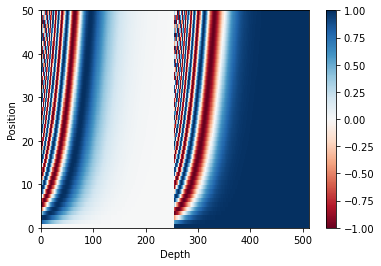

In [141]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [57]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * - 1e9)
    
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    
    return output

In [83]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0 
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        outputs = self.dense(concat_attention)
        
        return outputs

In [84]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] # [batch_size, 1, 1, sequence_length]

In [85]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


**0인 부분을 1로 표시합니다.**

In [86]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [87]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [88]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


**0이 있으면 패딩까지 하는 것을 볼 수 있습니다.**

In [95]:
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    attention = MultiHeadAttention(d_model, num_heads, name='attention')({
        'query':inputs, 'key':inputs, 'value':inputs, 'mask':padding_mask
    })
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [96]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
                                
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
                                
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
                                
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='encoder_layer_{}'.format(i),)([outputs, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
                                

In [97]:
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={
        'query':inputs, 'key':inputs, 'value':inputs, 'mask':look_ahead_mask
    })
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    attention2 = MultiHeadAttention(d_model, num_heads, name='attention_2')(inputs={
        'query':attention1, 'key':enc_outputs, 'value':enc_outputs, 'mask':padding_mask
    })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [101]:
def decoder(vocab_size, num_layers, units, d_model,num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='decoder_layer_{}'.format(i))(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [102]:
def transformer(vocab_size, num_layers,
               units, d_model, num_heads, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    # encoder에서 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    # decoder에서 미래 토큰 마스크, 패딩 마스크
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)
    # 두번째 어텐션 블록에서 encoder의 벡터들을 마스킹, decoder에서 패딩 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)
    
    # encoder
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask])
    # decoder
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # dense layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [103]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2  # encoder, decoder의 층 개수
D_MODEL = 256   # encoder, decoder 내부의 입/출력 고정 차원
NUM_HEADS = 8   # 멀티 헤드 어텐션의 헤드 수 
UNITS = 512     # feed forward 신경망 은닉층의 크기
DROPOUT = 0.1

model = transformer(vocab_size=VOCAB_SIZE, 
                   num_layers=NUM_LAYERS,
                   d_model=D_MODEL,
                   num_heads=NUM_HEADS,
                   units=UNITS,
                   dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

- loss function 구현

In [104]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

- Custom Learning rate Scheduling(커스텀 학습률 스케쥴링)
    - learning rate를 급격히 높였다가 서서히 낮추어 안정적으로 수렴하게 하는 기법

In [105]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

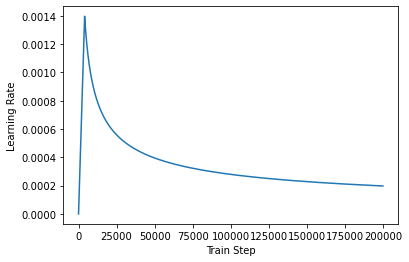

In [106]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [111]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [178]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 12s 63ms/step - loss: 0.0013 - accuracy: 0.2346
Epoch 2/20
185/185 [==============================] - 13s 68ms/step - loss: 0.0015 - accuracy: 0.2346
Epoch 3/20
185/185 [==============================] - 12s 63ms/step - loss: 0.0012 - accuracy: 0.2347
Epoch 4/20
185/185 [==============================] - 10s 54ms/step - loss: 0.0013 - accuracy: 0.2346
Epoch 5/20
185/185 [==============================] - 10s 55ms/step - loss: 0.0014 - accuracy: 0.2346
Epoch 6/20
185/185 [==============================] - 10s 55ms/step - loss: 0.0012 - accuracy: 0.2346
Epoch 7/20
185/185 [==============================] - 10s 55ms/step - loss: 0.0012 - accuracy: 0.2347
Epoch 8/20
185/185 [==============================] - 10s 55ms/step - loss: 0.0015 - accuracy: 0.2346
Epoch 9/20
185/185 [==============================] - 10s 55ms/step - loss: 0.0013 - accuracy: 0.2346
Epoch 10/20
185/185 [==============================] - 10s 55ms/step - loss: 0.001

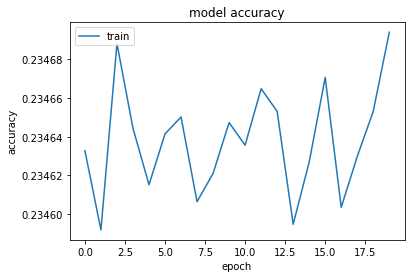

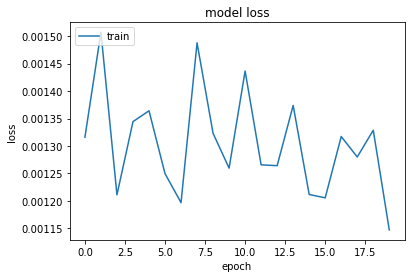

In [179]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## 05. 모델평가

In [180]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(predicted_id, END_TOKEN[0]): # 종료토큰 나오면 예측 종료
            break
            
        # 다시 디코더의 입력이 된다. 
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
        return tf.squeeze(output_sequence, axis=0)

In [181]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)
    
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))    
    
    return predicted_sentence

In [182]:
sentence_generation('오늘 날씨가 어때?')

입력 : 오늘 날씨가 어때?
출력 : 마음도 


'마음도 '

In [183]:
sentence_generation('놀러가고 싶다')

입력 : 놀러가고 싶다
출력 : 병원에 


'병원에 '

In [184]:
sentence_generation('밥을 안먹었더니 어지러워')

입력 : 밥을 안먹었더니 어지러워
출력 : 건강 


'건강 '

In [185]:
sentence_generation('여행지 추천해줄래?')

입력 : 여행지 추천해줄래?
출력 : 그가 


'그가 '

In [186]:
sentence_generation('안녕?')

입력 : 안녕?
출력 : 안녕하세요


'안녕하세요'

In [187]:
sentence_generation('반가워요')

입력 : 반가워요
출력 : 반갑


'반갑'

In [188]:
sentence_generation('몇 살이니?')

입력 : 몇 살이니?
출력 : 피


'피'

In [189]:
sentence_generation('어딜 가')

입력 : 어딜 가
출력 : 힘내지 


'힘내지 '

In [190]:
sentence_generation('배고프다')

입력 : 배고프다
출력 : 저도 


'저도 '

In [191]:
sentence_generation('같이 밥먹을래?')

입력 : 같이 밥먹을래?
출력 : 지


'지'

In [192]:
sentence_generation('이름이 뭐야?')

입력 : 이름이 뭐야?
출력 : 하고 


'하고 '

In [193]:
sentence_generation('내일은 비가 올까?')

입력 : 내일은 비가 올까?
출력 : 멋지게 


'멋지게 '

In [194]:
sentence_generation('답변을 좀 잘해줬으면 좋겠어')

입력 : 답변을 좀 잘해줬으면 좋겠어
출력 : 저도요


'저도요'

In [195]:
sentence_generation('왜 문장을 출력 못하니..?')

입력 : 왜 문장을 출력 못하니..?
출력 : 살다보면 


'살다보면 '

In [196]:
sentence_generation('안녕하세요')

입력 : 안녕하세요
출력 : 안녕하세요


'안녕하세요'

In [198]:
sentence_generation('안녕히가세요')

입력 : 안녕히가세요
출력 : 상처가 


'상처가 '

In [199]:
sentence_generation('오늘 공부 어렵다')

입력 : 오늘 공부 어렵다
출력 : 같이 


'같이 '

# 루브릭 평가
---
1. **한국어 전처리를 통해 학습 데이터셋을 구축하였다.**   

    - 한국어 데이터에 맞는 전처리를 수행했다.


2. **트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.**

    - 학습과정을 시각화해 정상적으로 수렴하는 것을 볼 수 있었다.
    
     
3. **한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.** 

    - 여러 문장에 대해 평가해보았다.

    
    
# 회고
---
## 어려웠던 점 
- 성능
    - 성능이 잘 안나왔고, 학습횟수를 늘이니 오히려 떨어졌다.
    - 갑자기 문장단위를 대답하지 않았다. 
    
## 알게된 점 
- 한국어 형태소 분석기 없이 토크나이징하는 방법 : SubwordTextEncoder

## 다짐
- 그동안 공부했던 트랜스포머를 직접 구현할 수 있었던 프로젝트이다. 구현하기 굉장히 까다로웠다. 여러 튜닝을 해보지 못했는데, 다음엔 한국어 전처리에 대해 더 다양하게 하고 싶다. 데이터 자체가 임의로 만들어낸 데이터라서 전처리 과정이 간결해도 성능이 괜찮았다고 생각한다. 